In [1]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

In [2]:
torch.manual_seed(111)

In [3]:
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [15]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

In [24]:
train_set = torchvision.datasets.FashionMNIST(
    root=".", train=True, download=True, transform=transform
)

100%|██████████████████████████████████████████████████████████████████████████████████| 26421880/26421880 [00:29<00:00, 891469.69it/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|████████████████████████████████████████████████████████████████████████████████████████| 29515/29515 [00:00<00:00, 263355.26it/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|███████████████████████████████████████████████████████████████████████████████████| 4422102/4422102 [00:04<00:00, 1049986.58it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|████████████████████████████████████████████████████████████████████████████████████████| 5148/5148 [00:00<00:00, 12387995.98it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



In [25]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

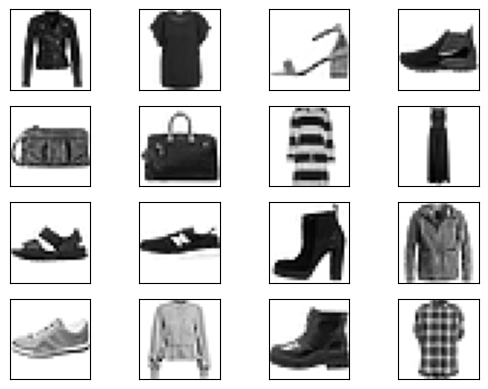

In [26]:
real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

In [27]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output

In [28]:
discriminator = Discriminator().to(device=device)

In [29]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

generator = Generator().to(device=device)

In [30]:
lr = 0.0001
num_epochs = 100
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [31]:
for epoch in range(num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(
            device=device
        )
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(
            device=device
        )
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels
        )
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.5321289896965027
Epoch: 0 Loss G.: 0.5417290925979614
Epoch: 1 Loss D.: 0.24184471368789673
Epoch: 1 Loss G.: 5.183775901794434
Epoch: 2 Loss D.: 0.09818550199270248
Epoch: 2 Loss G.: 3.9539425373077393
Epoch: 3 Loss D.: 0.08114500343799591
Epoch: 3 Loss G.: 5.749997138977051
Epoch: 4 Loss D.: 0.18723836541175842
Epoch: 4 Loss G.: 3.8626034259796143
Epoch: 5 Loss D.: 0.3041790723800659
Epoch: 5 Loss G.: 2.377776622772217
Epoch: 6 Loss D.: 0.19137437641620636
Epoch: 6 Loss G.: 2.2163119316101074
Epoch: 7 Loss D.: 0.419977068901062
Epoch: 7 Loss G.: 1.423084020614624
Epoch: 8 Loss D.: 0.29378482699394226
Epoch: 8 Loss G.: 1.4336678981781006
Epoch: 9 Loss D.: 0.5673843026161194
Epoch: 9 Loss G.: 1.5496132373809814
Epoch: 10 Loss D.: 0.5340702533721924
Epoch: 10 Loss G.: 1.4023375511169434
Epoch: 11 Loss D.: 0.5736700296401978
Epoch: 11 Loss G.: 1.587213397026062
Epoch: 12 Loss D.: 0.36062294244766235
Epoch: 12 Loss G.: 1.2550671100616455
Epoch: 13 Loss D.: 0.6159818172

In [34]:
latent_space_samples = torch.randn(batch_size, 100).to(device=device)
generated_samples = generator(latent_space_samples)

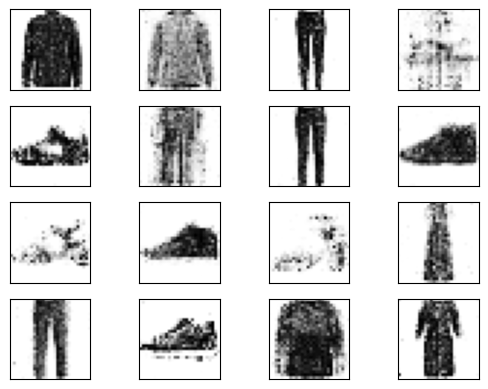

In [35]:
generated_samples = generated_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])